In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import ViTFeatureExtractor, TFViTModel
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Reshape, Layer
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [2]:
with zipfile.ZipFile("/content/cats_and_dogs_filtered.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/sample_data")

train_dir = "/content/sample_data"

# Step 2: Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Step 3: Create data generators
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize to [0, 1]
    validation_split=0.2  # 20% for validation
)

# Training generator (80% of training data)
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

# Validation generator (20% of training data)
val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42
)


Found 2400 images belonging to 1 classes.
Found 600 images belonging to 1 classes.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5357 - loss: 0.6878

75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 266ms/step - accuracy: 0.5378 - loss: 0.6873 - val_accuracy: 0.9700 - val_loss: 0.5670
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9469 - loss: 0.5350

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9472 - loss: 0.5346 - val_accuracy: 1.0000 - val_loss: 0.4307
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9932 - loss: 0.4216 - val_accuracy: 1.0000 - val_loss: 0.3333
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 1.0000 - loss: 0.3375 - val_accuracy: 1.0000 - val_loss: 0.2637
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 1.0000 - loss: 0.2772 - val_accuracy: 1.0000 - val_loss: 0.2133
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 1.0000 - loss: 0.2286 - val_accuracy: 1.0000 - val_loss: 0.1756
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 1.0000 - loss: 0.1931 - val_accuracy: 1.0000 - val_loss: 0.1467
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 1.0000 - loss: 0.1650 - val_accuracy: 1.0000 - val_loss: 0.1247
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 1.0000 - loss: 0.1408 - val_accuracy: 1.0000 - val_loss: 0.

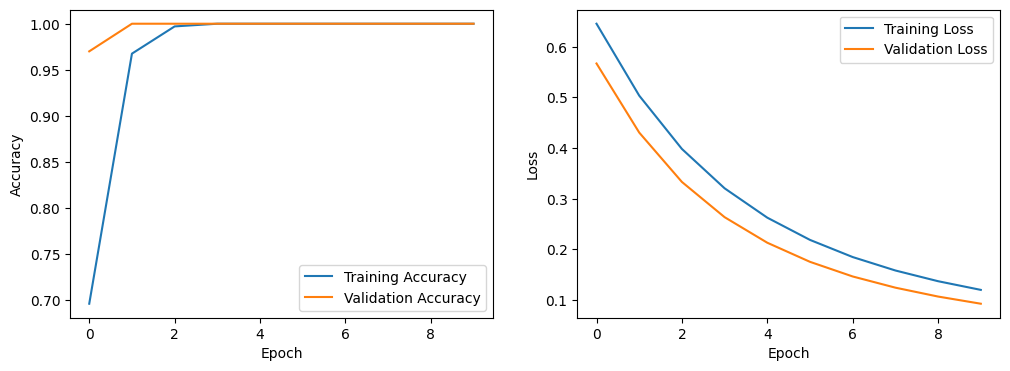

In [3]:
EPOCHS = 10
class ViTModelLayer(layers.Layer):
    def __init__(self, vit_model, **kwargs):
        super(ViTModelLayer, self).__init__(**kwargs)
        self.vit_model = vit_model

    def call(self, inputs):
        inputs = tf.transpose(inputs, [0, 3, 1, 2])
        vit_output = self.vit_model(pixel_values=inputs).last_hidden_state[:, 0]
        return vit_output

    def get_config(self):
        config = super().get_config()
        # Can't serialize vit_model, so you should handle loading manually
        return config

IMG_SIZE = 224
def create_vit_model(num_classes):
    vit_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
    input_layer = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    vit_output = ViTModelLayer(vit_model)(input_layer)
    output_layer = layers.Dense(num_classes, activation='sigmoid')(vit_output)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model


num_classes = 1
vit_model = create_vit_model(num_classes)
vit_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "vit_cat_dog_checkpoint.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

csv_logger = tf.keras.callbacks.CSVLogger("training_log.csv")

vit_history = vit_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, csv_logger]
)

val_loss, val_accuracy = vit_model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vit_history.history['accuracy'], label='Training Accuracy')
plt.plot(vit_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vit_history.history['loss'], label='Training Loss')
plt.plot(vit_history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3883 - loss: 1.6934

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 92s 48ms/step - accuracy: 0.3883 - loss: 1.6932 - val_accuracy: 0.6365 - val_loss: 1.0481
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6195 - loss: 1.1019

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.6195 - loss: 1.1018 - val_accuracy: 0.6733 - val_loss: 0.9368
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6687 - loss: 0.9515

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.6687 - loss: 0.9514 - val_accuracy: 0.6874 - val_loss: 0.9033
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7051 - loss: 0.8640

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.7051 - loss: 0.8640 - val_accuracy: 0.7244 - val_loss: 0.8050
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.7277 - loss: 0.7916 - val_accuracy: 0.7242 - val_loss: 0.8218
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7473 - loss: 0.7349

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.7473 - loss: 0.7349 - val_accuracy: 0.7314 - val_loss: 0.7951
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7609 - loss: 0.6920

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.7609 - loss: 0.6920 - val_accuracy: 0.7419 - val_loss: 0.7865
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7735 - loss: 0.6478

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.7735 - loss: 0.6478 - val_accuracy: 0.7472 - val_loss: 0.7683
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7846 - loss: 0.6162

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.7846 - loss: 0.6162 - val_accuracy: 0.7541 - val_loss: 0.7406
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.7963 - loss: 0.5874 - val_accuracy: 0.7477 - val_loss: 0.8012
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7509 - loss: 0.7371
Test Accuracy: 0.7541


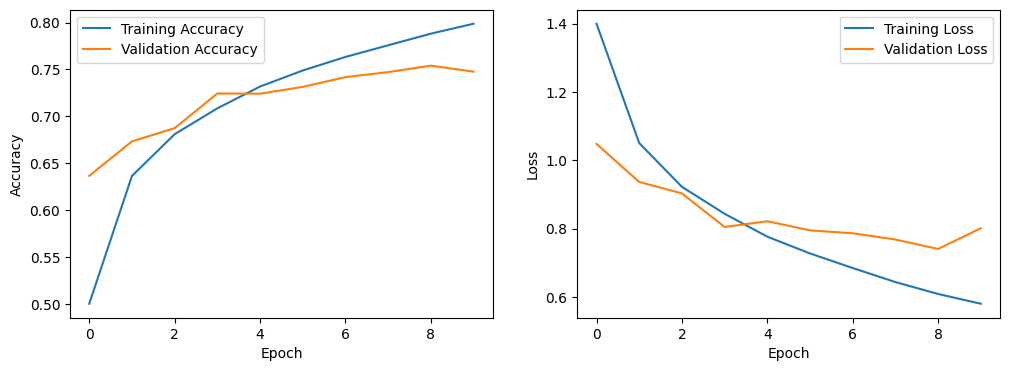

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Reshape, Layer
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

# === CONFIG ===
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 10

class ViTBlock(Layer):
    def __init__(self, num_heads, ff_dim, dropout=0.1):
        super(ViTBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(ff_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_hybrid_model():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    vgg_output = base_model.get_layer('block5_conv3').output
    vgg_model = Model(inputs=base_model.input, outputs=vgg_output)

    for layer in vgg_model.layers:
        layer.trainable = False

    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = vgg_model(inputs)
    x = Reshape((196, 512))(x)

    x = ViTBlock(num_heads=8, ff_dim=512)(x)
    x = ViTBlock(num_heads=8, ff_dim=512)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train, y_test = y_train.squeeze(), y_test.squeeze()

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000)
train_ds = train_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

model = build_hybrid_model()
optimizer = Adam(learning_rate=1e-4, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb = ModelCheckpoint("hybrid_vgg16_vit.h5", save_best_only=True)
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[checkpoint_cb])

model.load_weights("hybrid_vgg16_vit.h5")
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
